In [1]:
%%capture
!pip install -i https://test.pypi.org/simple/ gis-utils-pkg-dillhicks==0.0.76
!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
!apt-get install python-numpy python-scipy -y
!pip install rasterio
!pip install fiona
!pip install geopandas
!pip install pygeos
import gdal 

In [1]:
from tqdm.autonotebook import tqdm 
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt 
import rasterio 
import geopandas as gpd
from gis_utils import raster, ml, shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
!pip install pygeos

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Function for getting files needed for data generation process from the drive
from os.path import join

def get_filelist():
    cur = []
    dest = "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Machine Learning/Training Images/Hybrid CNN/"

    #horrible search method, do not do this, only works because how we specifically set up the drive structure

    #iterating through all files in orthomosaics directory
    for root, dirs, files in os.walk("/content/drive/Shared drives/SIO and E4E Mangroves /Data/Orthomosaics/"):
        for file in files:
            #finding all normal tifs
            if not(("dem" in file) or ("DEM" in file) or ("downsampled" in file) or ("CNN_prob" in file) or ("planetscope" in file) or ("kompsat" in file)) and not(file.startswith("un_")) and not(file.endswith("CNN_nm.tif")) and not(file.endswith("CNN_m.tif")) and not(file.startswith("prob_"))  and  (file.endswith(".tif")):
                #detecting planetscope images
                for ortho in os.listdir(root):
                    if ("planetscope" in ortho):
                        
                        #get shapefiles from classifications folder
                        for subroot, subdirs, subfiles in os.walk(root):
                            zero = "0.shp"
                            one = "1.shp"
                            
                            #iterating through files in 
                            for subfile in subfiles:
                                if (subfile == zero) or (subfile == one):
                                    #since we will get dupicates
                                    file_list = [join(root,ortho),
                                                 join(subroot,zero),
                                                 join(subroot,one)
                                                ]
                                    if not(file_list in cur):
                                        cur.append(file_list)
                                    



    return cur

In [4]:
def rasterize_one(shp,img,meta,geometry="geometry",label="label"):
    size = (img.height,img.width)
    out_array = np.ones(size)
    shapes = ((geom,value) for geom, value in zip(shp[geometry], shp[label]))
    burned = features.rasterize(shapes=shapes, fill=0, out=out_array, transform=img.transform)
    burned = 1-burned
    return burned

In [5]:
def rasterize_zero(shp,img,meta,geometry="geometry",label="label"):
    size = (img.height,img.width)
    out_array = np.zeros(size)
    shapes = ((geom,value) for geom, value in zip(shp[geometry], shp[label]))
    burned = features.rasterize(shapes=shapes, fill=0, out=out_array, transform=img.transform)
    return burned

In [14]:
!cp -r "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Labelled Data/GMW Labels/GMW_001_GlobalMangroveWatch_2016/01_Data" data

In [6]:
from rasterio import features
from rasterio.features import shapes
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image
from shapely.geometry import box


# Generating Label Data for each site

In [15]:
gmw = gpd.read_file("/content/data/01_Data/GMW_2016_v2_fixed.shp")

In [8]:
import sklearn

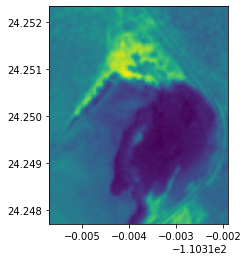

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  app.launch_new_instance()


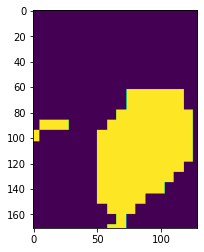

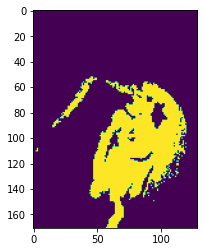

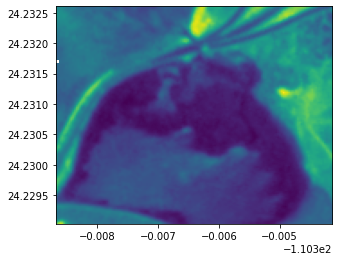

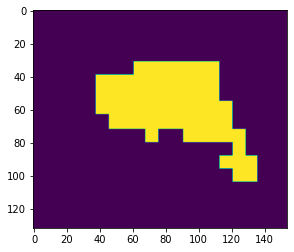

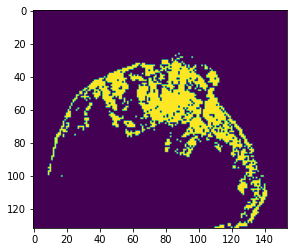

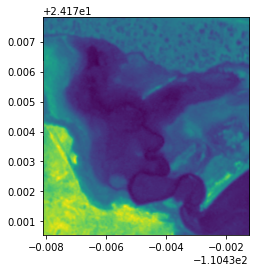

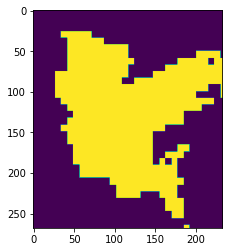

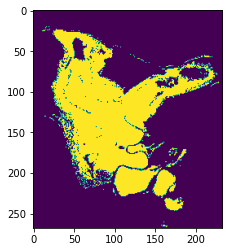

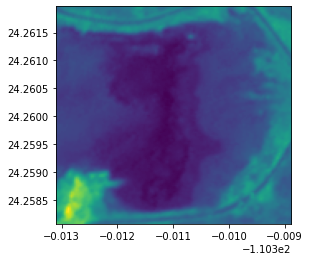

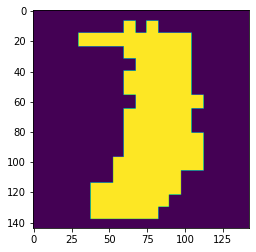

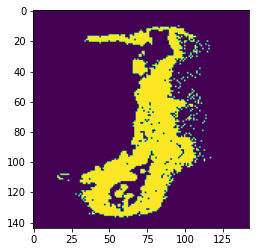

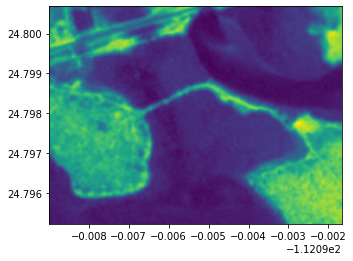

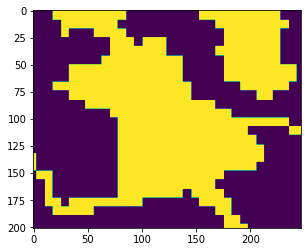

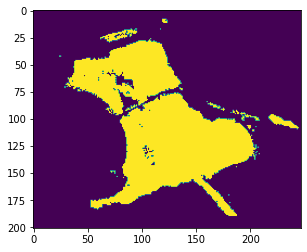

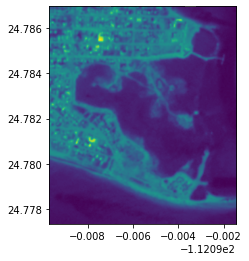

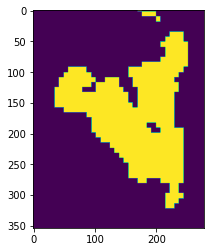

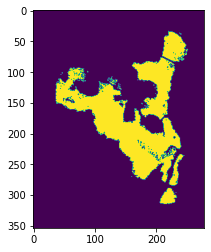

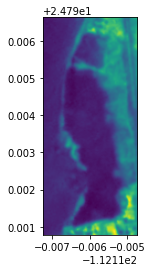

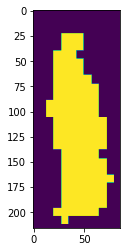

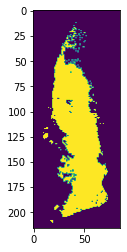

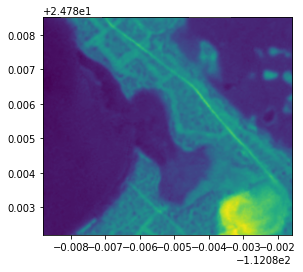

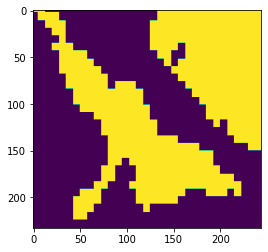

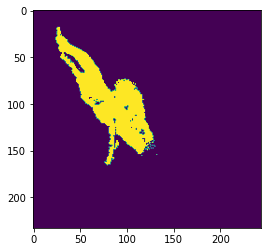

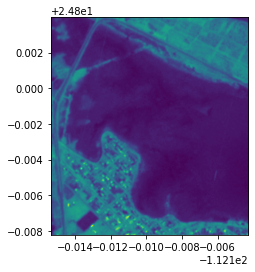

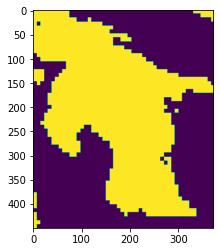

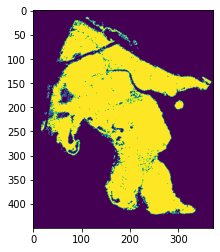

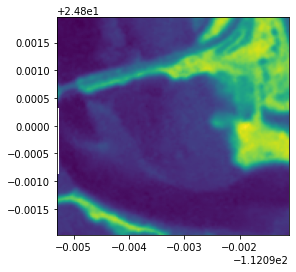

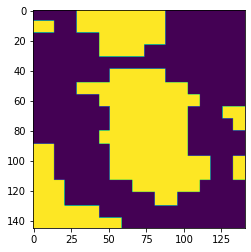

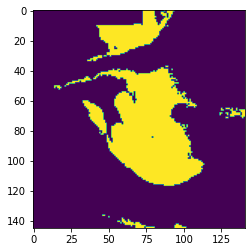

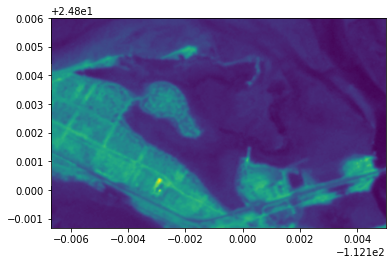

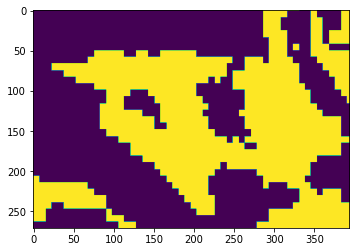

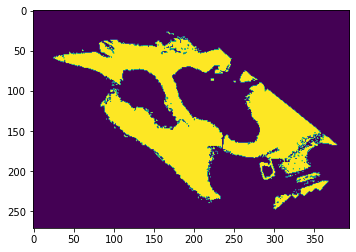

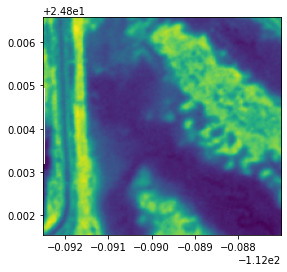

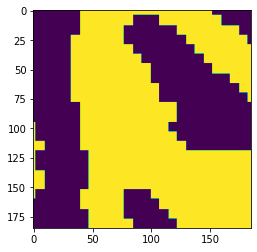

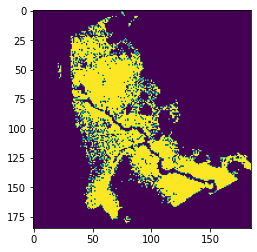

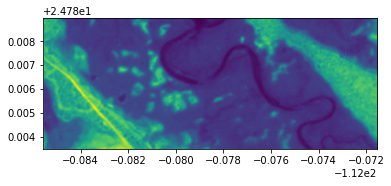

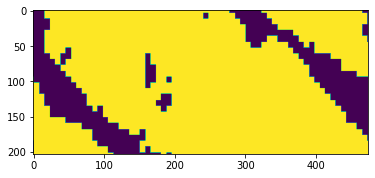

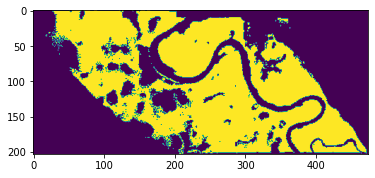

In [16]:
file_list = get_filelist()

for i, site in enumerate(file_list):

    !cp {"\"" + site[0] + "\""} "planetscope.tif"

    img, meta = raster.load_image("planetscope.tif")

    zero_shp = gpd.read_file(site[1])
    one_shp = gpd.read_file(site[2])

    show(img)

    df = gpd.GeoDataFrame({"id":1,"geometry":[box(*img.bounds)]})

    points_clip = gpd.clip(gmw, df)

    gmw_label = rasterize_zero(points_clip,img, meta, label="pxlval")
    show(gmw_label)

    label = rasterize_zero(zero_shp,img, meta, label="label")
    show(label)

    if i == 0:
        y = label.flatten()
        x = gmw_label.flatten()

    else:
        y = np.concatenate((y.flatten(),label.flatten()))
        x = np.concatenate((x.flatten(),gmw_label.flatten()))



In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def pixel_iou(y_true,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    iou = tp / (tp + fn + fp)
    return iou


print("Accuracy: ", accuracy_score(x, y))

print("Intersection over Union (IOU): ", pixel_iou(x, y))

Accuracy:  0.7803896046878591
Intersection over Union (IOU):  0.5424937523033758
